# Exploratory Data Analysis (EDA) de Accidentes de Tráfico

### 1. Importación de librerías
Importamos las librerías fundamentales para nuestro EDA:

- azure.storage.blob nos permite conectar y descargar datos desde Azure Blob Storage.

- pandas es la librería principal para manipulación de datos tabulares.

- seaborn y matplotlib se usarán para la visualización gráfica.

- numpy y math facilitan operaciones numéricas y matemáticas.

In [1]:
from azure.storage.blob import BlobServiceClient
from io import BytesIO
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### 2. Conexión y carga de datos
Cargamos nuestros datos en un pandas df, ya que tiene mejor compatibilidad con librerías de visualización como matplotlib o seaborn. Si tuvieramos un df mayor (+100k registros) sería mejor práctica hacer el EDA con PySpark o cargar solo una parte del df en el pandas df.

In [ ]:
# Parámetros de conexión
storage_account_name = "accidentesml9046401304"
# Mala práctica: deberíamos pasar la clave como variable de entorno
# No tuvimos tiempo de cambiarlo
storage_account_key = "qPblehKg+PRBtekunhfYQOHNjG0slqHHu4/A4GqcJ60iWPr/cFAI0t9n8hrdexfQuZr/vYR5k+4m+AStpXAPtg=="
container_name = "raw-data"
folder = "ingesta/ingesta_output.parquet/"

# Conexión al servicio
blob_service_client = BlobServiceClient(
    account_url=f"https://{storage_account_name}.blob.core.windows.net",
    credential=storage_account_key
)

# Listar blobs dentro del "directorio"
container_client = blob_service_client.get_container_client(container_name)
blobs = container_client.list_blobs(name_starts_with=folder)

# Filtrar el primer archivo que empiece por "part"
part_file = next((b.name for b in blobs if b.name.startswith(folder + "part")), None)

if not part_file:
    raise FileNotFoundError("No se encontró ningún archivo que empiece por 'part' en la ruta especificada.")

# Descargar y leer como parquet
blob_client = blob_service_client.get_blob_client(container=container_name, blob=part_file)
stream = BytesIO(blob_client.download_blob().readall())
df = pd.read_parquet(stream)

print(f"✅ Archivo leído: {part_file}")

✅ Archivo leído: ingesta/ingesta_output.parquet/part-00000-21cf3284-6333-4f78-b78a-3f7ab434b258-c000.snappy.parquet


### 3. Configuración global de los gráficos
Definimos el estilo visual y parámetros generales para los gráficos con seaborn y matplotlib,
como tamaño de figuras, tamaño de texto en ejes y títulos, y el estilo de fondo.  
Esto asegura que todas las visualizaciones tengan un formato limpio y consistente a lo largo del análisis.

In [3]:
# Configuración visual
sns.set(style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.titlepad": 15,
})

### 4. Información general del dataset
Mostramos la cantidad de filas y columnas para entender el tamaño del dataset.
También listamos los tipos de datos de las columnas y mostramos las primeras filas para inspección rápida.  
Esta vista inicial nos da una idea de la estructura y contenido de los datos que vamos a explorar.

In [4]:
# Info general
print(f"Filas: {df.shape[0]:,} | Columnas: {df.shape[1]}")
print("\nTipos de datos:")
print(df.dtypes.value_counts())
display(df.head())

Filas: 97,916 | Columnas: 76

Tipos de datos:
int64      65
float64     8
object      3
dtype: int64


,ID_ACCIDENTE,CARRETERA,KM,ANYO,MES,DIA_SEMANA,HORA,COD_PROVINCIA,COD_MUNICIPIO,ISLA,...,CONDICION_ILUMINACION,CONDICION_METEO,CONDICION_NIEBLA,CONDICION_VIENTO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA,TRAFICO_LIGERO,TRAFICO_PESADO,TRAFICO_TOTAL
0,3,N-104,362.0,2022,1,6,21,1,00000,NaN,...,6,2,NaN,NaN,1,998,2,NaN,NaN,NaN
1,4,BI-636,14.0,2022,1,7,12,1,00000,NaN,...,1,3,NaN,NaN,1,998,1,NaN,NaN,NaN
2,8,AP-68,30.0,2022,1,5,7,1,00000,NaN,...,1,1,NaN,NaN,1,998,3,NaN,NaN,NaN
3,12,A-1,389.0,2022,1,7,20,1,00000,NaN,...,6,4,NaN,NaN,1,998,1,NaN,NaN,NaN
4,19,No inventariada,0.0,2022,1,7,19,1,01036,NaN,...,6,2,NaN,NaN,1,998,998,NaN,NaN,NaN


### 5. Análisis de valores nulos
Identificamos qué columnas tienen valores faltantes y cuántos.
Visualizamos esta información en un gráfico de barras para facilitar su interpretación.
Detectar nulos es fundamental para planificar cómo tratarlos en nuestra limpieza.

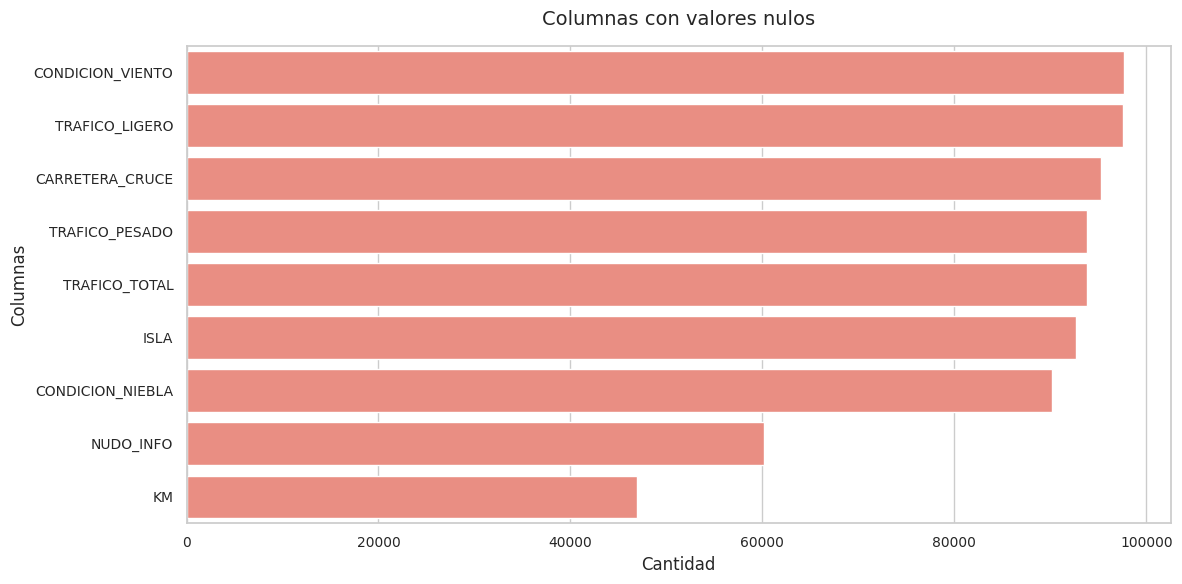

In [5]:
# Nulos
nulos = df.isnull().sum().sort_values(ascending=False)
nulos = nulos[nulos > 0]

if not nulos.empty:
    sns.barplot(x=nulos.values, y=nulos.index, color='salmon')
    plt.title("Columnas con valores nulos")
    plt.xlabel("Cantidad")
    plt.ylabel("Columnas")
    plt.tight_layout()
    plt.show()

### 6. Detección de filas duplicadas
Calculamos cuántas filas duplicadas existen y su porcentaje sobre el total.  
Eliminar duplicados puede ser necesario para evitar sesgos o errores en el análisis, en nuestro caso no tenemos. 

In [6]:
# Duplicados
duplicados = df.duplicated().sum()
print(f"Filas duplicadas: {duplicados:,} ({duplicados / df.shape[0] * 100:.2f}%)")

Filas duplicadas: 0 (0.00%)


### 7. Detección de outliers

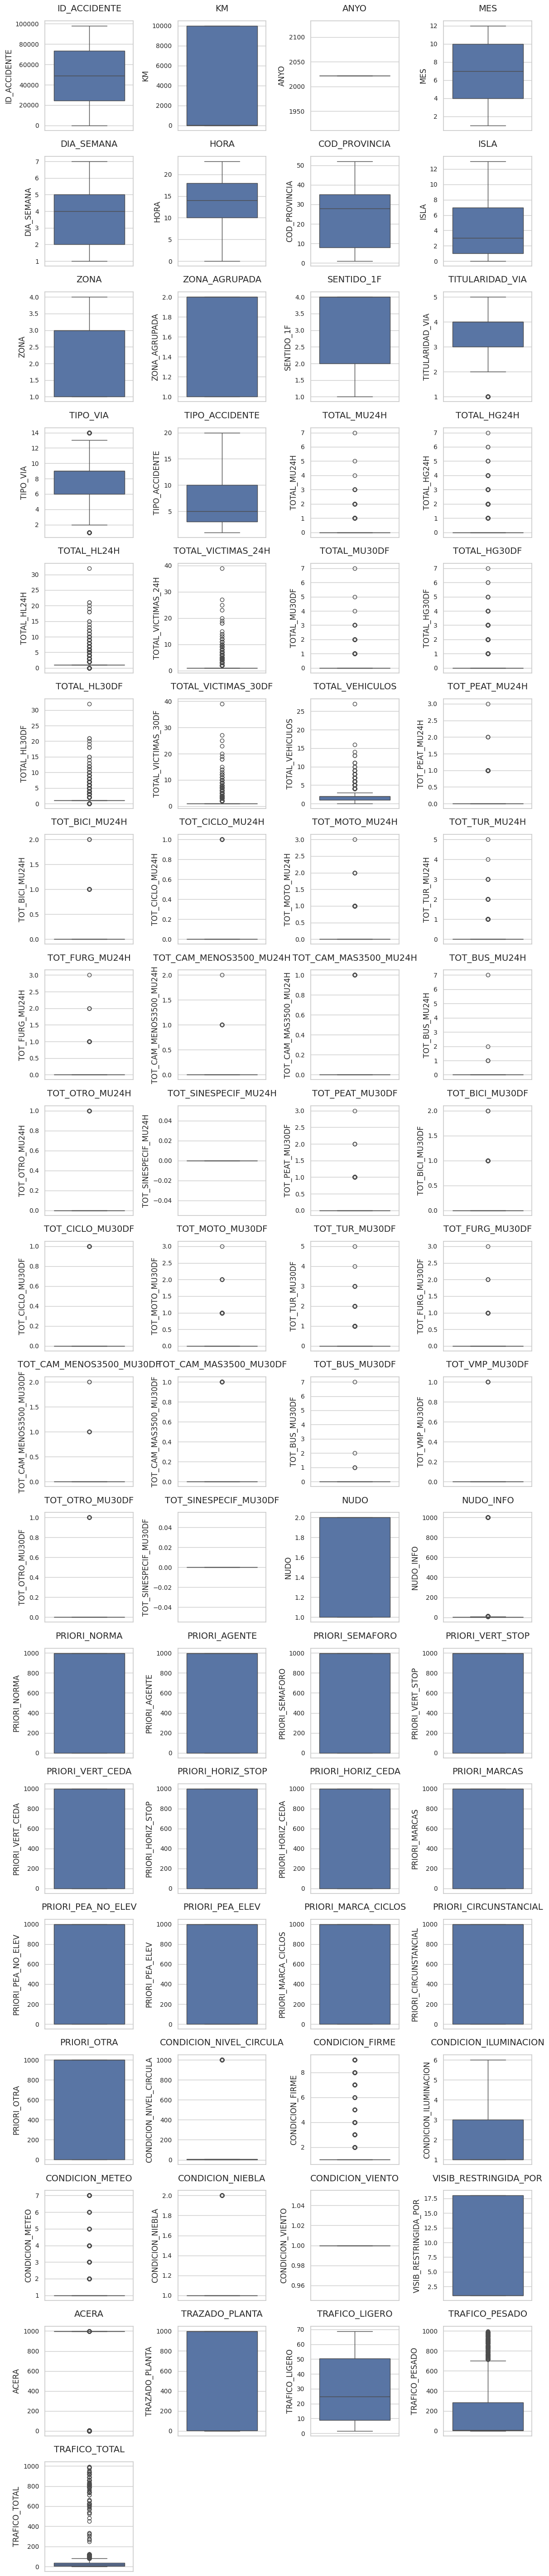

In [7]:
# Filtrar solo columnas numéricas
numeric_cols = df.select_dtypes(include='number').columns.tolist()

# Nº por fila
cols_per_row = 4
n_rows = math.ceil(len(numeric_cols) / cols_per_row)

# Tamaño de cada subplot
fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(cols_per_row * 3, n_rows * 3))
axes = axes.flatten()  

# Generar boxplots por columna
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("") 

# Ocultar subplots vacíos (si los hay)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

### 8. Estadísticas descriptivas básicas
Generamos estadísticas resumen para todas las variables, incluyendo conteos, medias, desviaciones, percentiles, y valores únicos.  
Esto nos ayuda a comprender la distribución y características básicas de cada variable, y detectar posibles anomalías.

In [8]:
# Estadísticas
display(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID_ACCIDENTE,97916.0,NaN,NaN,NaN,48958.5,28266.058816,1.0,24479.75,48958.5,73437.25,97916.0
CARRETERA,97916,5382,No inventariada,63911,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KM,50944.0,NaN,NaN,NaN,2921.186212,4481.189495,0.0,6.3,44.7,9999.0,9999.0
ANYO,97916.0,NaN,NaN,NaN,2022.0,0.0,2022.0,2022.0,2022.0,2022.0,2022.0
MES,97916.0,NaN,NaN,NaN,6.664835,3.368126,1.0,4.0,7.0,10.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...
ACERA,97916.0,NaN,NaN,NaN,899.874157,296.649393,1.0,998.0,998.0,998.0,999.0
TRAZADO_PLANTA,97916.0,NaN,NaN,NaN,642.873136,477.039092,1.0,3.0,998.0,998.0,998.0
TRAFICO_LIGERO,394.0,NaN,NaN,NaN,29.622746,21.817421,1.638,8.8525,24.85,50.296,68.846
TRAFICO_PESADO,4107.0,NaN,NaN,NaN,162.210031,259.97804,1.004,3.595,8.325,284.0,997.0


### 9. Análisis temporal
Vamos a analizar la cantidad de accidentes según las variables temporales de nuestro dataset para ver como está distribuída nuestra información y detectar patrones.

- **9.1. ANALISIS POR MES** : Visualizamos la frecuencia de accidentes por cada mes del año, permitiendo detectar patrones o temporadas con mayor siniestralidad. Se puede comprobar un ligero crecimiento en los meses de verano.


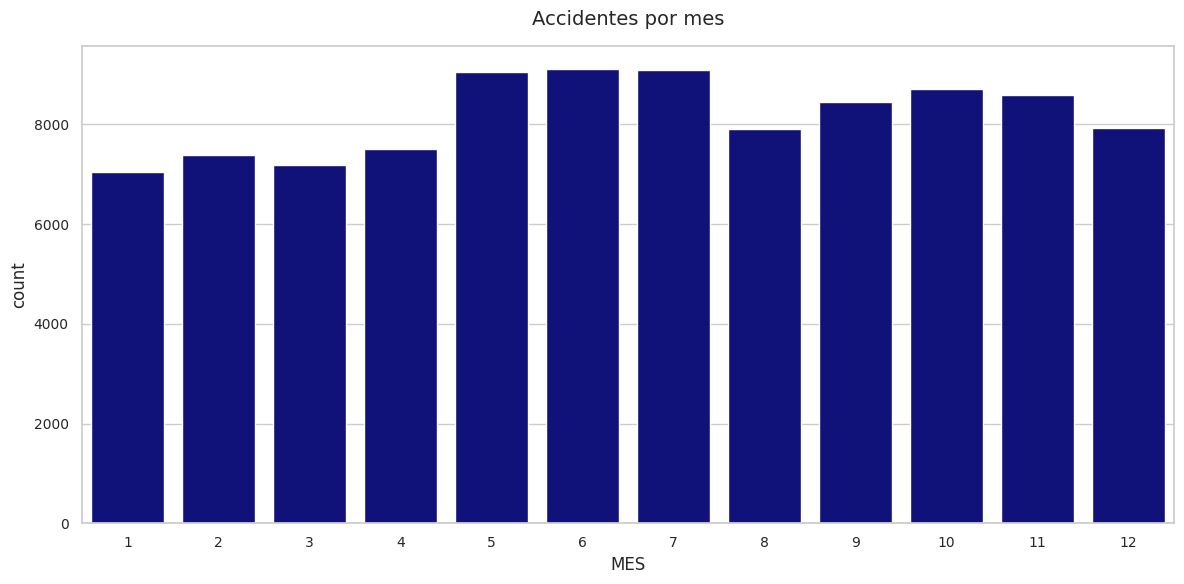

In [9]:
# Análisis por mes
df['FECHA'] = pd.to_datetime(dict(year=df['ANYO'], month=df['MES'], day=1), errors='coerce')

sns.countplot(data=df, x='MES', color='darkblue')
plt.title("Accidentes por mes")
plt.tight_layout()
plt.show()


- **9.2 ANALISIS POR DIA** : Visualizamos la cantidad de accidentes según el día de la semana para identificar qué días presentan más siniestros.
Este insight puede ayudar en la planificación de medidas preventivas focalizadas. Se puede comprobar un ligero decrecimiento en los días no laborales.

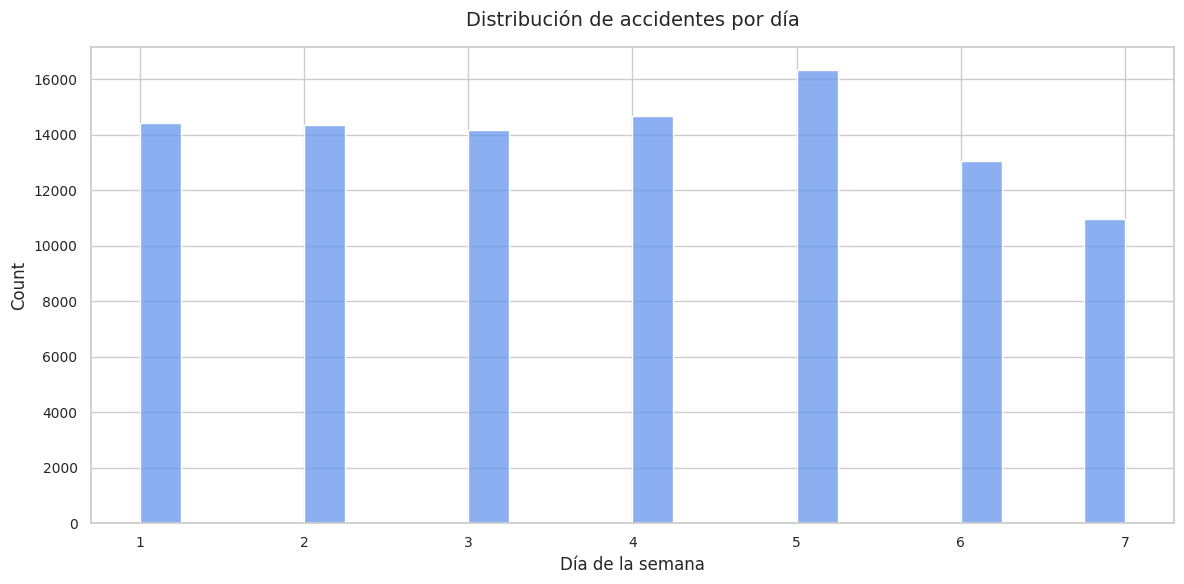

In [10]:
# Análisis por día
sns.histplot(df['DIA_SEMANA'].dropna(), bins=24, color='cornflowerblue')
plt.title("Distribución de accidentes por día")
plt.xlabel("Día de la semana")
plt.tight_layout()
plt.show()

- **9.3 ANALISIS POR HORA** : Mostramos cómo se distribuyen los accidentes a lo largo de las 24 horas del día, destacando horas punta o momentos críticos.
Es útil para entender la dinámica temporal diaria y enfocar intervenciones. Se puede comprobar el crecimiento durante el mediodía.

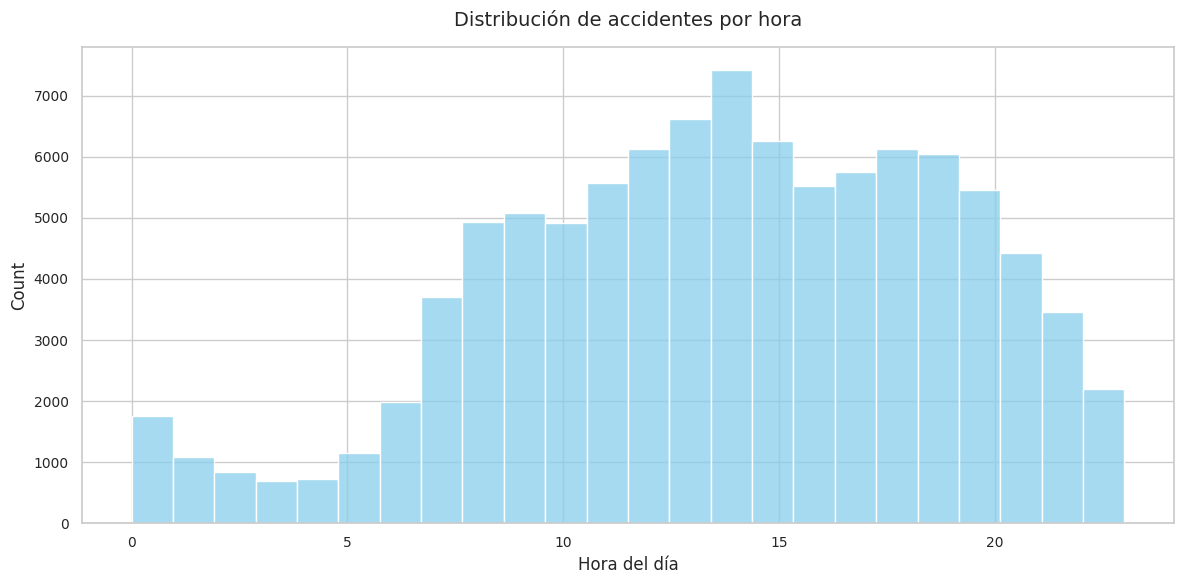

In [11]:
# Análisis por hora
sns.histplot(df['HORA'].dropna(), bins=24, color='skyblue')
plt.title("Distribución de accidentes por hora")
plt.xlabel("Hora del día")
plt.tight_layout()
plt.show()

### 10. Análisis espacial - Provincias con más accidentes
Visualizamos las 10 provincias con mayor número de accidentes.
Esto aporta información geográfica para priorizar regiones de atención y estudio.
El 8 es Barcelona, el 28 Madrid y el 29 Málaga.

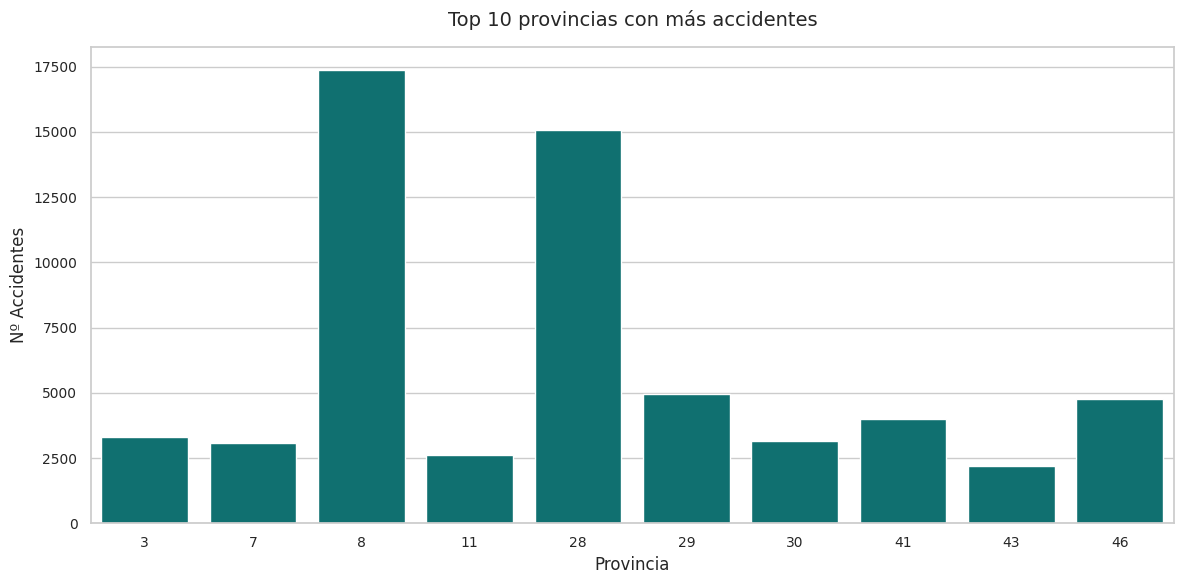

In [12]:
# Análisis espacial
top_prov = df['COD_PROVINCIA'].value_counts().head(10)
sns.barplot(x=top_prov.index, y=top_prov.values, color='teal')
plt.title("Top 10 provincias con más accidentes")
plt.xlabel("Provincia")
plt.ylabel("Nº Accidentes")
plt.tight_layout()
plt.show()

### 11. Estadísticas de víctimas y gravedad
Mostramos boxplots para variables relacionadas con víctimas mortales y graves en diferentes periodos (24h y 30 días).
Esta visualización permite detectar la distribución, posibles valores atípicos y variabilidad en las cifras de víctimas.

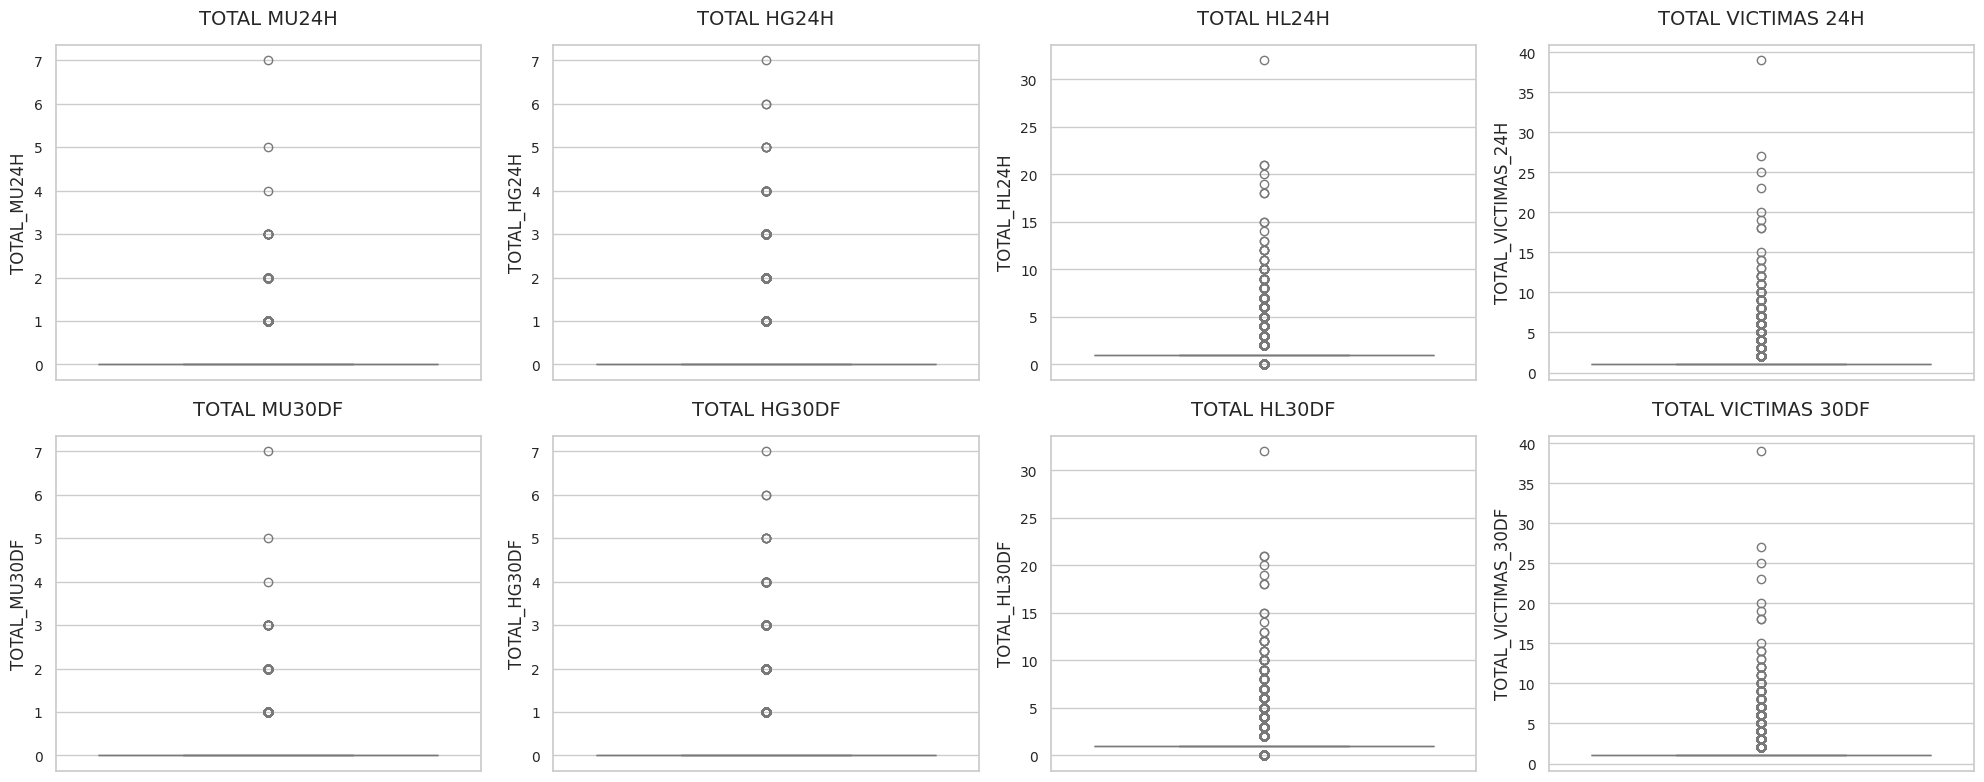

In [13]:
# Víctimas y gravedad
victimas_cols = [
    "TOTAL_MU24H", "TOTAL_HG24H", "TOTAL_HL24H", "TOTAL_VICTIMAS_24H",
    "TOTAL_MU30DF", "TOTAL_HG30DF", "TOTAL_HL30DF", "TOTAL_VICTIMAS_30DF"
]

n_cols = 4
n_rows = math.ceil(len(victimas_cols) / n_cols)
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(victimas_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(col.replace("_", " "))

plt.tight_layout()
plt.show()


### 12.Correlación entre variables relevantes
Calculamos y graficamos la matriz de correlación entre variables temporales, espaciales, tipo de accidente y víctimas.
Este análisis ayuda a entender relaciones y asociaciones entre características clave.

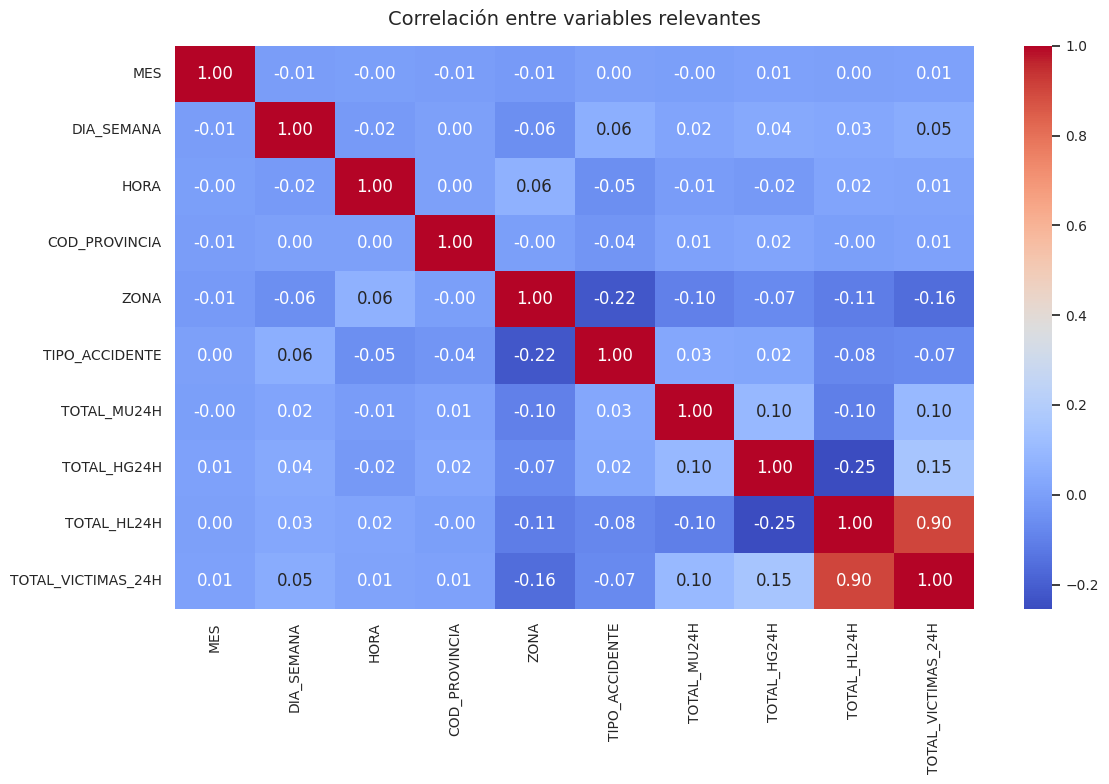

In [14]:
# Correlaciones
cols_interes = [
    "MES", "DIA_SEMANA", "HORA", "COD_PROVINCIA", "ZONA",
    "TIPO_ACCIDENTE", "TOTAL_MU24H", "TOTAL_HG24H", "TOTAL_HL24H", "TOTAL_VICTIMAS_24H"
]

plt.figure(figsize=(12, 8))
sns.heatmap(df[cols_interes].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre variables relevantes")
plt.tight_layout()
plt.show()

### 13. Tipos de accidentes más comunes
Mostramos un gráfico de barras con los tipos de accidentes más frecuentes.
Esto es útil para focalizar la prevención y recursos en las categorías más relevantes. El 2 es fronto-lateral, el 4 por alcance y el 7 atropello a personas.

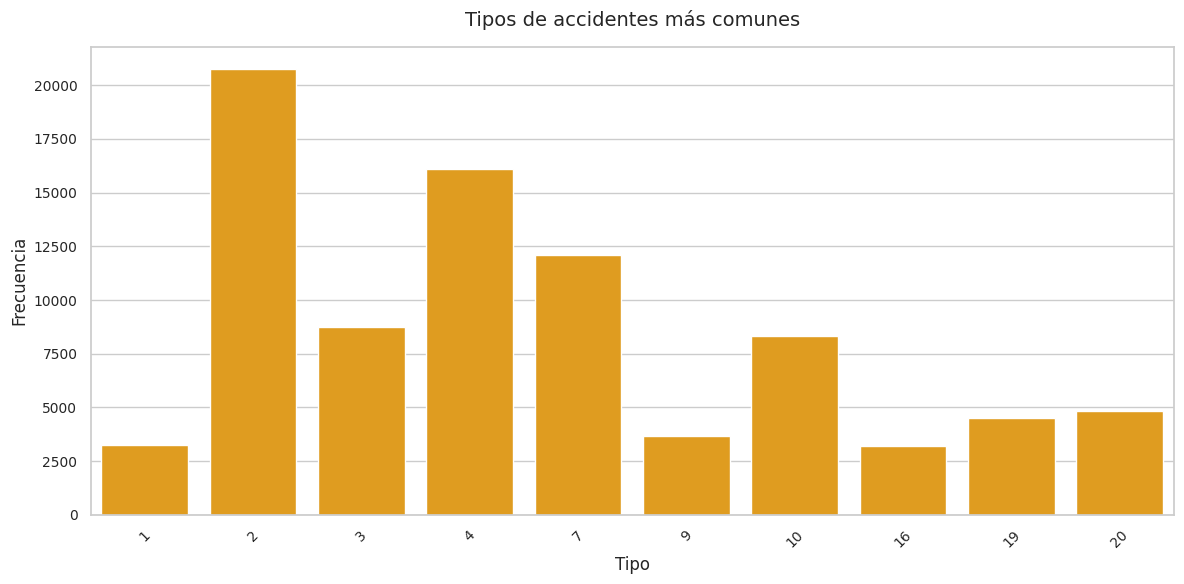

In [15]:
# Tipos de accidentes
top_tipos = df["TIPO_ACCIDENTE"].value_counts().head(10)
sns.barplot(x=top_tipos.index, y=top_tipos.values, color='orange')
plt.title("Tipos de accidentes más comunes")
plt.xticks(rotation=45)
plt.xlabel("Tipo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

### 14. Condiciones ambientales
Analizamos la distribución de accidentes según condiciones meteorológicas y de iluminación.
Comprender estos factores permite evaluar su impacto y diseñar estrategias específicas. En la metereología el 1 es despejado, el 3 es lluvia débil y el 2 nublado. en la iluminación el 1 es luz de día natural y el 4 es con luz artificial.

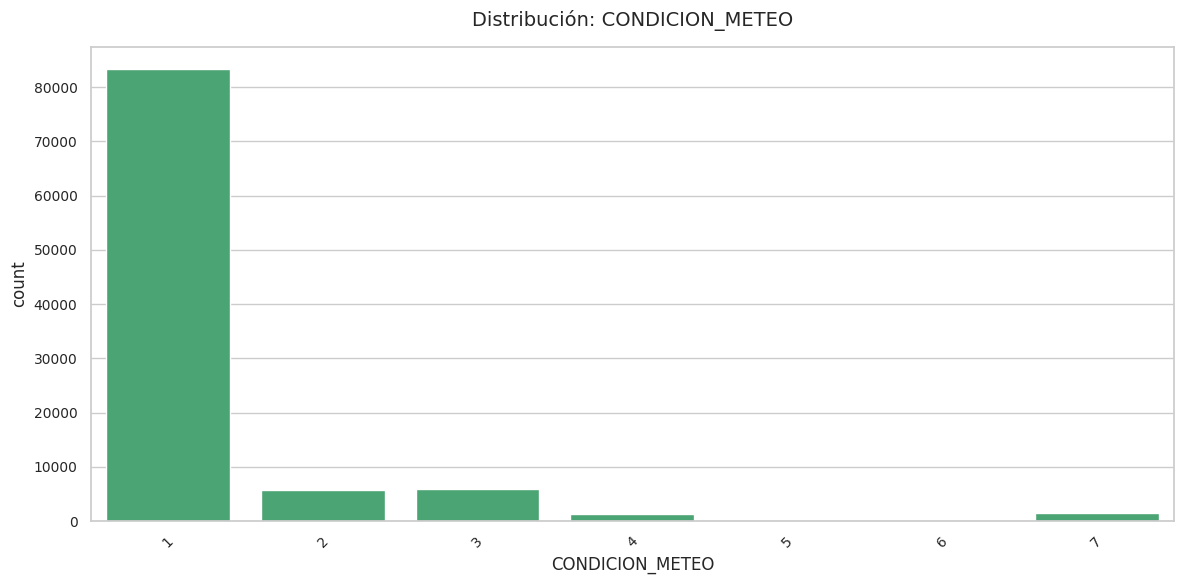

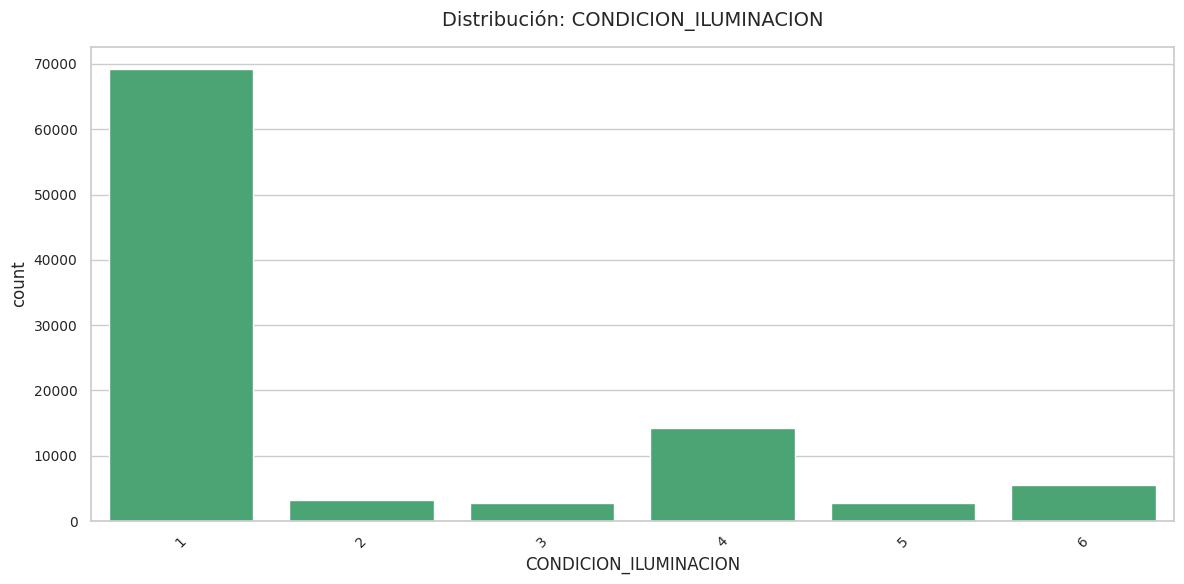

In [16]:
# Condiciones ambientales
cond_cols = ["CONDICION_METEO", "CONDICION_ILUMINACION"]

for col in cond_cols:
    if col in df.columns:
        sns.countplot(data=df, x=col, color="mediumseagreen")
        plt.title(f"Distribución: {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### 15. Fallecidos por tipo de vehículo
Sumamos el total de fallecidos en accidentes según el tipo de vehículo involucrado y lo visualizamos.
Esto aporta información valiosa sobre la peligrosidad relativa de distintos vehículos para orientar políticas y campañas.

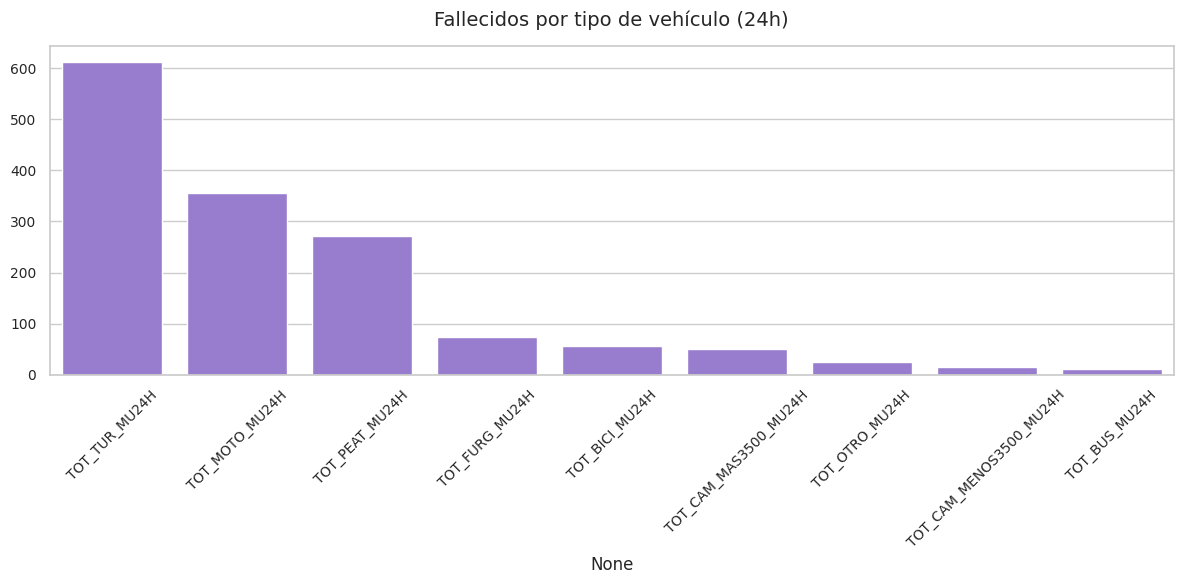

In [17]:
# Fallecidos por tipo de vehículo
veh_cols = [
    "TOT_PEAT_MU24H", "TOT_BICI_MU24H", "TOT_MOTO_MU24H", "TOT_TUR_MU24H", 
    "TOT_FURG_MU24H", "TOT_CAM_MENOS3500_MU24H", "TOT_CAM_MAS3500_MU24H", 
    "TOT_BUS_MU24H", "TOT_OTRO_MU24H"
]

veh_sum = df[veh_cols].sum().sort_values(ascending=False)
sns.barplot(x=veh_sum.index, y=veh_sum.values, color='mediumpurple')
plt.title("Fallecidos por tipo de vehículo (24h)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()